<a href="https://colab.research.google.com/github/ojuskumar/DataAnalysisProjects/blob/master/demo_3ddfa_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A simple demostration of how to run

In [ ]:
# cleaning
# %rm -rf /content/3DDFA_V2

In [ ]:
# if not clone, clone it
%cd /content
!git clone https://github.com/cleardusk/3DDFA_V2.git
%cd 3DDFA_V2

/content
Cloning into '3DDFA_V2'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 607 (delta 59), reused 85 (delta 39), pack-reused 489
Receiving objects: 100% (607/607), 73.13 MiB | 34.86 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/content/3DDFA_V2


In [ ]:
!sh ./build.sh

running build_ext
cythoning nms/cpu_nms.pyx to nms/cpu_nms.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/3DDFA_V2/FaceBoxes/utils/nms/cpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'nms.cpu_nms' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/nms
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c nms/cpu_nms.c -o build/temp.linux-x86_64-3.6/nms/cpu_nms.o -Wno-cpp -Wno-unused-function
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wforma

In [ ]:
# before import, make sure FaceBoxes and Sim3DR are built successfully, e.g.,

import cv2
import yaml

from FaceBoxes import FaceBoxes
from TDDFA import TDDFA
from utils.render import render
from utils.depth import depth
from utils.pncc import pncc
from utils.uv import uv_tex
from utils.pose import viz_pose
from utils.serialization import ser_to_ply, ser_to_obj
from utils.functions import draw_landmarks, get_suffix

import matplotlib.pyplot as plt
from skimage import io

### Load configs

In [ ]:
# load config
cfg = yaml.load(open('configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    !pip install onnxruntime
    
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    from FaceBoxes.FaceBoxes_ONNX import FaceBoxes_ONNX
    from TDDFA_ONNX import TDDFA_ONNX

    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    face_boxes = FaceBoxes()
    tddfa = TDDFA(gpu_mode=False, **cfg)

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:958: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:958: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input output
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))
/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:958: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input alpha_shp
  'Automatically generated names will be applied to each dynamic axes of input {}'.format(key))
/usr/local/lib/python3.6/dist-packa

Convert /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.pth to /content/3DDFA_V2/FaceBoxes/weights/FaceBoxesProd.onnx done.
Convert configs/bfm_noneck_v3.pkl to configs/bfm_noneck_v3.onnx done.
weights/mb1_120x120.onnx does not exist, try to convert the `.pth` version to `.onnx` online
Convert weights/mb1_120x120.pth to weights/mb1_120x120.onnx done.


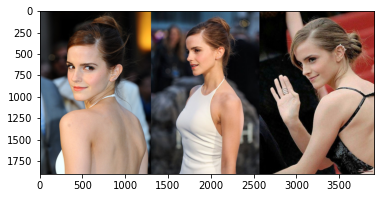

In [ ]:
# given an image path or the image url

# img_fp = 'examples/inputs/emma.jpg'
# img = cv2.imread(img_fp)
# plt.imshow(img[..., ::-1])

img_url = 'https://raw.githubusercontent.com/cleardusk/3DDFA_V2/master/examples/inputs/emma.jpg'
img = io.imread(img_url)
plt.imshow(img)

img = img[..., ::-1]  # RGB -> BGR

### Detect faces using FaceBoxes

In [ ]:
# face detection
boxes = face_boxes(img)
print(f'Detect {len(boxes)} faces')
print(boxes)

Detect 3 faces
[[1699.8103, 278.4466, 2057.8765, 762.2303, 0.999949], [2999.4954, 305.0812, 3428.5447, 900.97614, 0.99989545], [317.43112, 399.97055, 792.7798, 1048.0317, 0.99988735]]


### Regressing 3DMM parameters, reconstruction and visualization

In [ ]:
# regress 3DMM params
param_lst, roi_box_lst = tddfa(img, boxes)

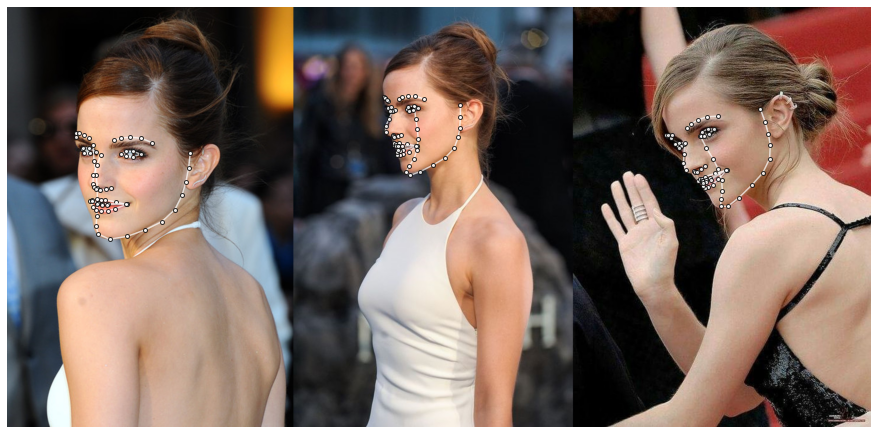

In [ ]:
# reconstruct vertices and visualizing sparse landmarks
dense_flag = False
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

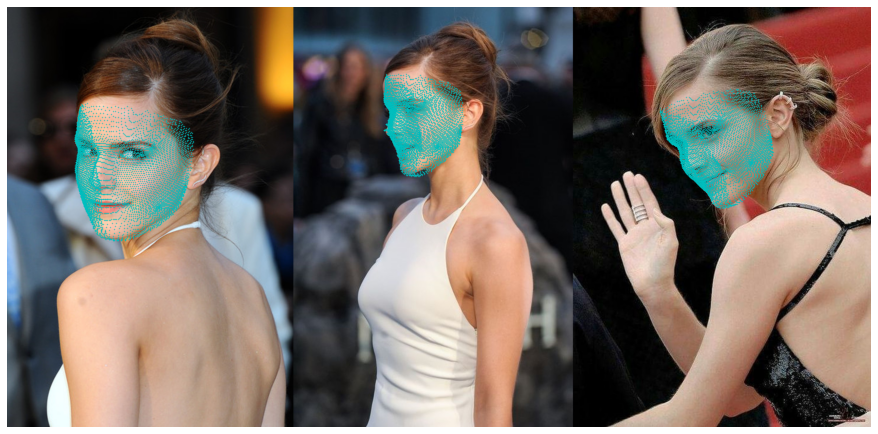

In [ ]:
# reconstruct vertices and visualizing dense landmarks
dense_flag = True
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

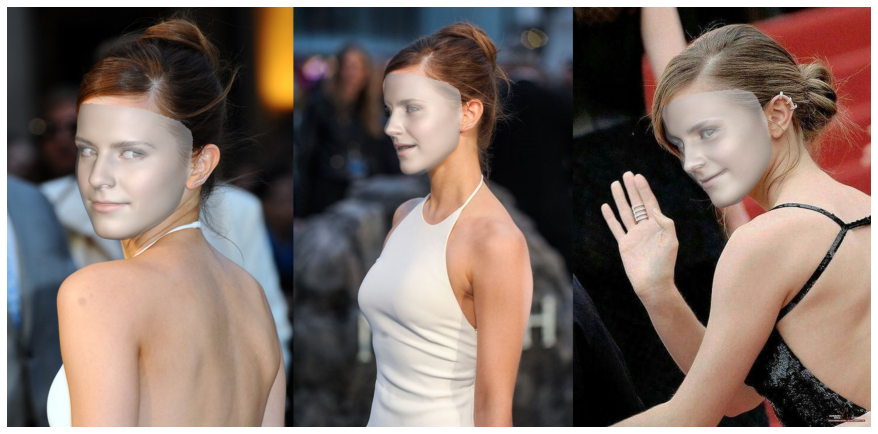

In [ ]:
# reconstruct vertices and render
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
render(img, ver_lst, tddfa.tri, alpha=0.6, show_flag=True);

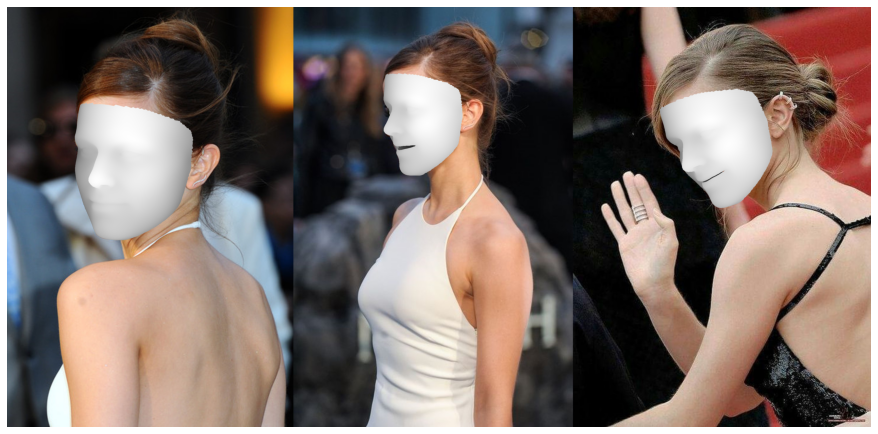

In [ ]:
# reconstruct vertices and render depth
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
depth(img, ver_lst, tddfa.tri, show_flag=True);

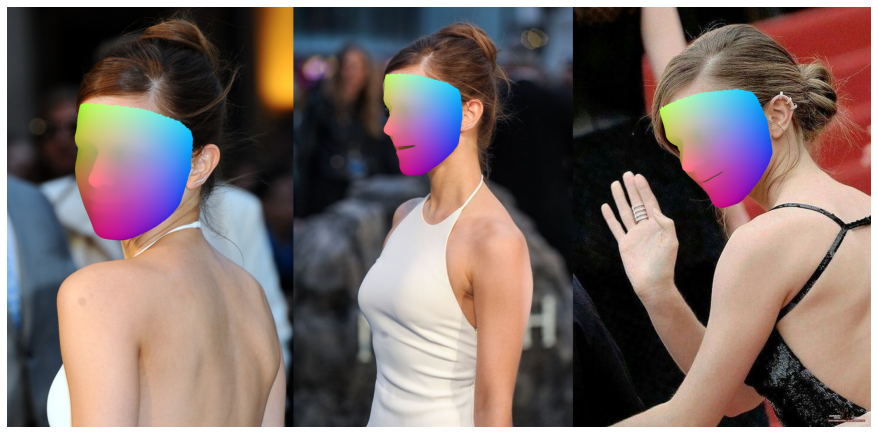

In [ ]:
# reconstruct vertices and render pncc
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
pncc(img, ver_lst, tddfa.tri, show_flag=True);

In [ ]:
# running offline
%%bash
for OPT in 2d_sparse 2d_dense 3d depth pncc pose uv_tex ply obj; do
  python demo.py -f examples/inputs/trump_hillary.jpg -o $OPT --show_flag=false --onnx;
done;

Detect 2 faces
Save visualization result to examples/results/trump_hillary_2d_sparse.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_2d_dense.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_3d.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_depth.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_pncc.jpg
Detect 2 faces
yaw: -14.8, pitch: 7.3, roll: 14.9
yaw: -22.0, pitch: 7.5, roll: 8.1
Save visualization result to examples/results/trump_hillary_pose.jpg
Detect 2 faces
Save visualization result to examples/results/trump_hillary_uv_tex.jpg
Detect 2 faces
Dump tp examples/results/trump_hillary_ply.ply
Detect 2 faces
Dump tp examples/results/trump_hillary_obj.obj
